# Filling large gaps in time series using forecasting

## Context

This notebook has the pourpose to show an easy approach to fill large gaps in time series, mantainign a certain veridicity and data validity. The approach consist in apply a forecasting in both sides of the gap, and combine the two prediction using interpolation. As shown in the specific case of this notebook, we can apply this approach also to attach consequential files, concerning same data entity. Moreover this specific case we are going to use esponential smoothing with seasonality, indulging the characteristic of our time series, but the approach can obviously be repeated with the most suitable forecasting tecnique for each single case.

## Libraries 



In [1]:
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
plt.rcParams['figure.dpi']= 300  #resolution

## Data

Data are divided into three separated text files. Every dataset is composed by the same columns.
Surveys have been recorded minutes by minutes, and there are no missing rows. 
The dirst columns of the txt files contains the date time, that is parsed by Pandas and used as index. In fact is important to have the index weel formatted.


In [2]:
df1 = pd.read_csv('datatest.txt',index_col=1,parse_dates=True)
df1.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
2015-02-02 14:19:00,140,23.7000,26.272,585.200000,749.200000,0.004764,1
2015-02-02 14:19:59,141,23.7180,26.290,578.400000,760.400000,0.004773,1
2015-02-02 14:21:00,142,23.7300,26.230,572.666667,769.666667,0.004765,1
2015-02-02 14:22:00,143,23.7225,26.125,493.750000,774.750000,0.004744,1
2015-02-02 14:23:00,144,23.7540,26.200,488.600000,779.000000,0.004767,1


In [3]:
df1.index

DatetimeIndex(['2015-02-02 14:19:00', '2015-02-02 14:19:59',
               '2015-02-02 14:21:00', '2015-02-02 14:22:00',
               '2015-02-02 14:23:00', '2015-02-02 14:23:59',
               '2015-02-02 14:25:00', '2015-02-02 14:25:59',
               '2015-02-02 14:26:59', '2015-02-02 14:28:00',
               ...
               '2015-02-04 10:34:00', '2015-02-04 10:34:59',
               '2015-02-04 10:36:00', '2015-02-04 10:37:00',
               '2015-02-04 10:38:00', '2015-02-04 10:38:59',
               '2015-02-04 10:40:00', '2015-02-04 10:40:59',
               '2015-02-04 10:41:59', '2015-02-04 10:43:00'],
              dtype='datetime64[ns]', length=2665, freq=None)

Let's procede in cleaning our data... First and last id of the index are used to create an ordered index.

In [7]:
#First dataset
df1 = pd.read_csv('datatest.txt',index_col=1,parse_dates=True)
df1.set_index(pd.date_range(start=df1.index[0], end=df1.index[-1], freq='min'), inplace=True)
df1.drop(['date','Occupancy','Light'], axis=1, inplace=True)

#Second dataset
df2=pd.read_csv(r'datatraining.txt', index_col=1,parse_dates=True)
df2.set_index(pd.date_range(start=df2.index[0], end=df2.index[-1], freq='min'), inplace=True)
df2.drop(['date','Occupancy','Light'], axis=1, inplace=True)

#Third dataset
df3= pd.read_csv('datatest2.txt',index_col=1,parse_dates=True)
df3.set_index(pd.date_range(start=df3.index[0], end=df3.index[-1], freq='min'), inplace=True)
df3.drop(['date','Occupancy','Light'], axis=1, inplace=True)

df1.head()

,Temperature,Humidity,CO2,HumidityRatio
2015-02-02 14:19:00,23.7000,26.272,749.200000,0.004764
2015-02-02 14:20:00,23.7180,26.290,760.400000,0.004773
2015-02-02 14:21:00,23.7300,26.230,769.666667,0.004765
2015-02-02 14:22:00,23.7225,26.125,774.750000,0.004744
2015-02-02 14:23:00,23.7540,26.200,779.000000,0.004767


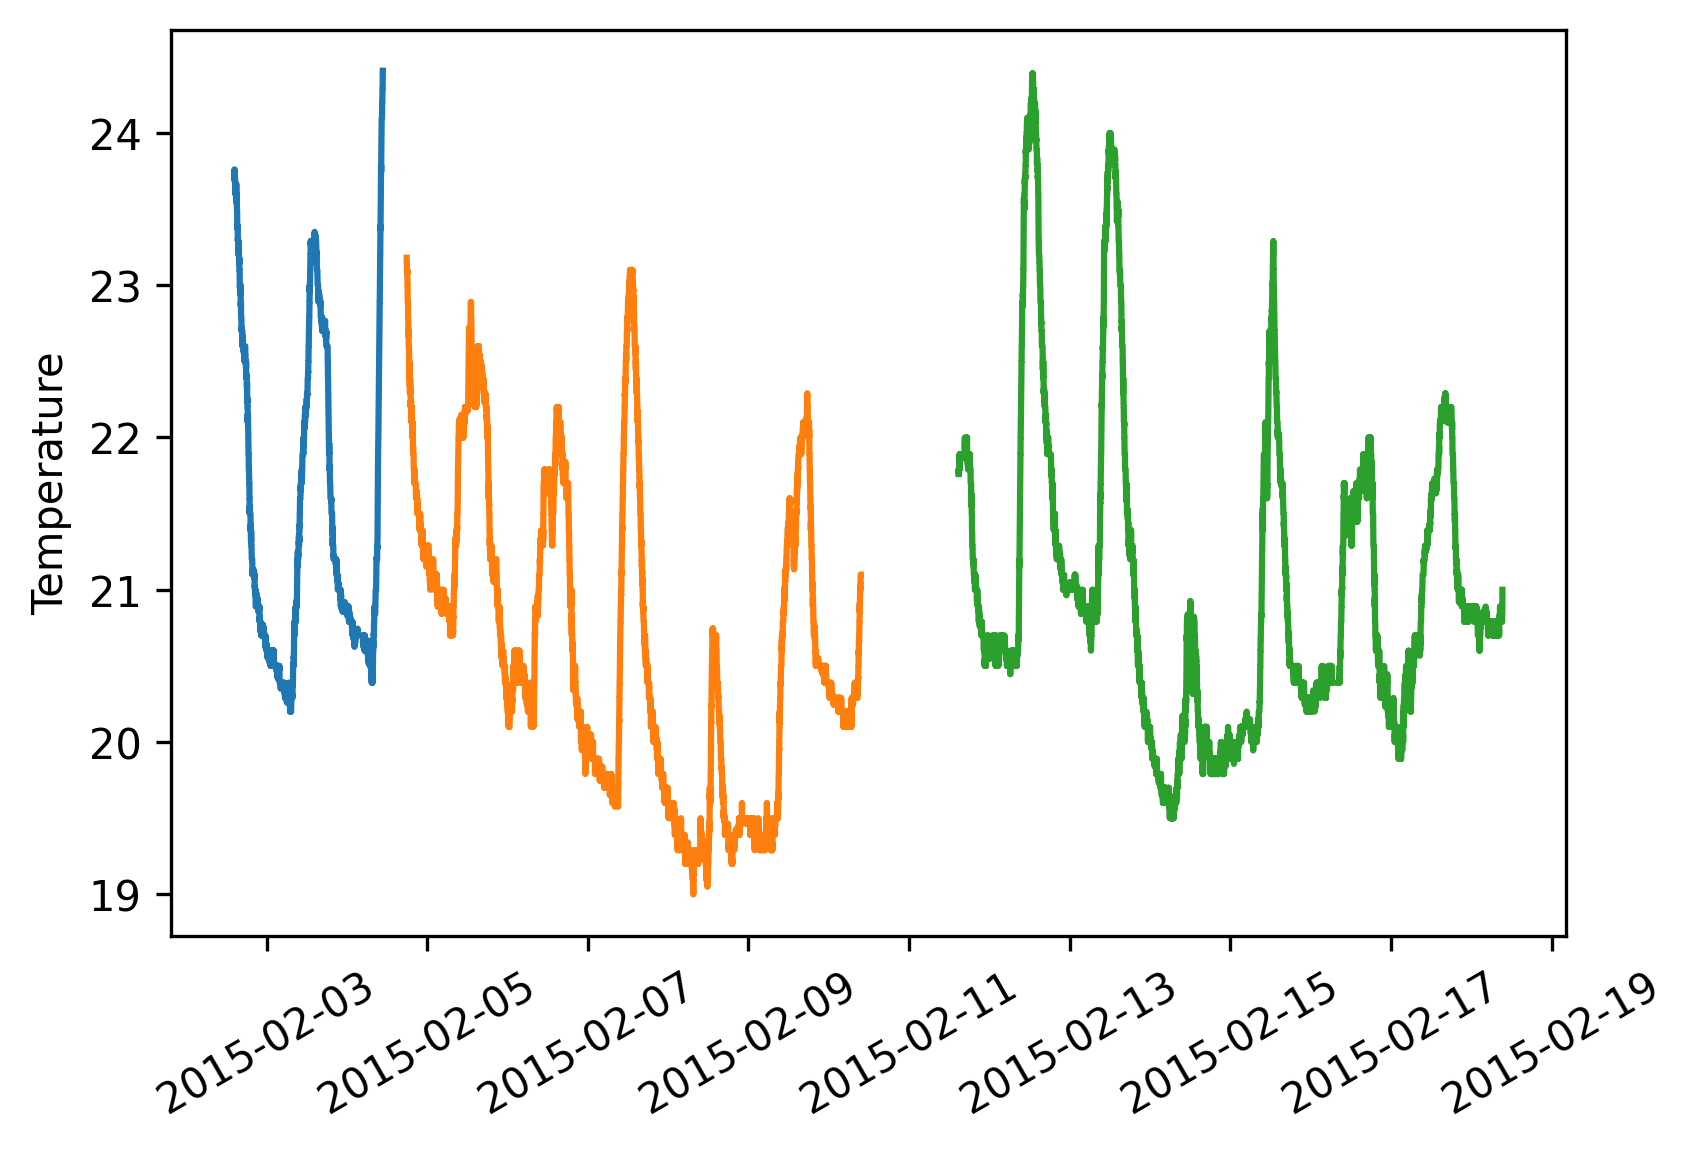

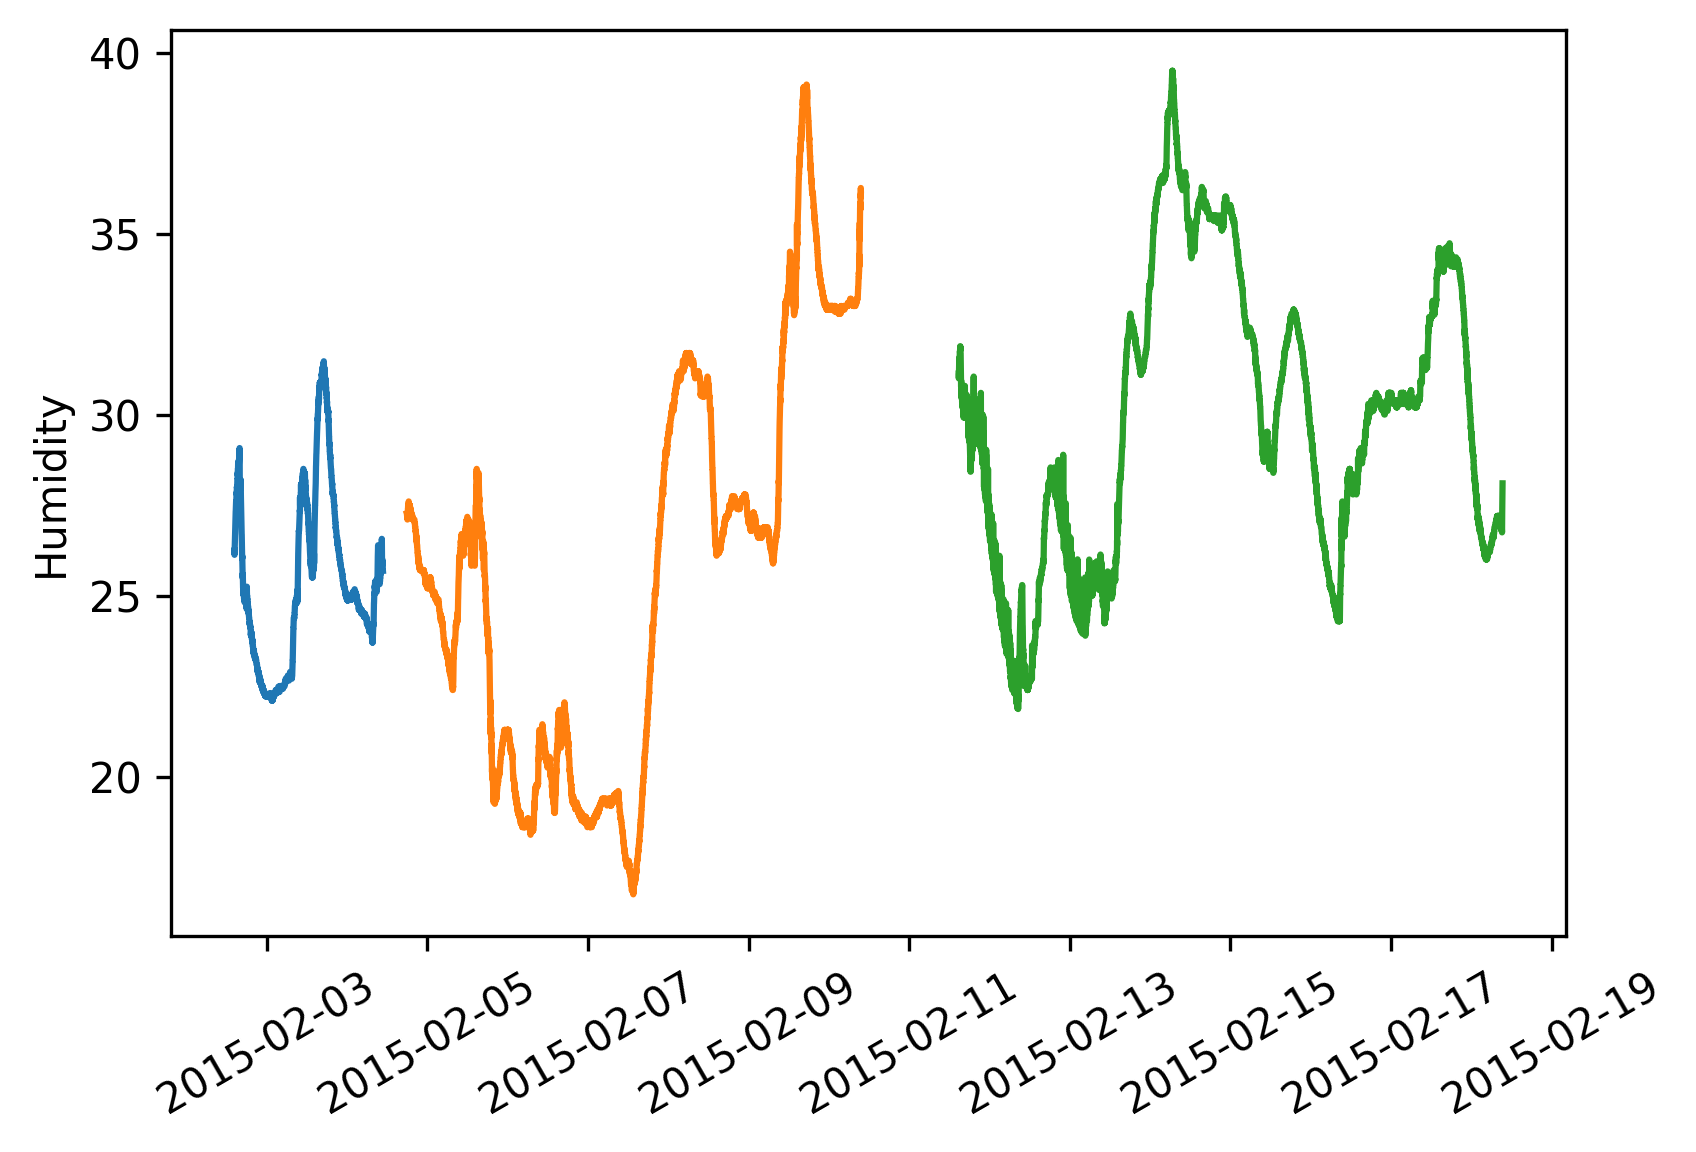

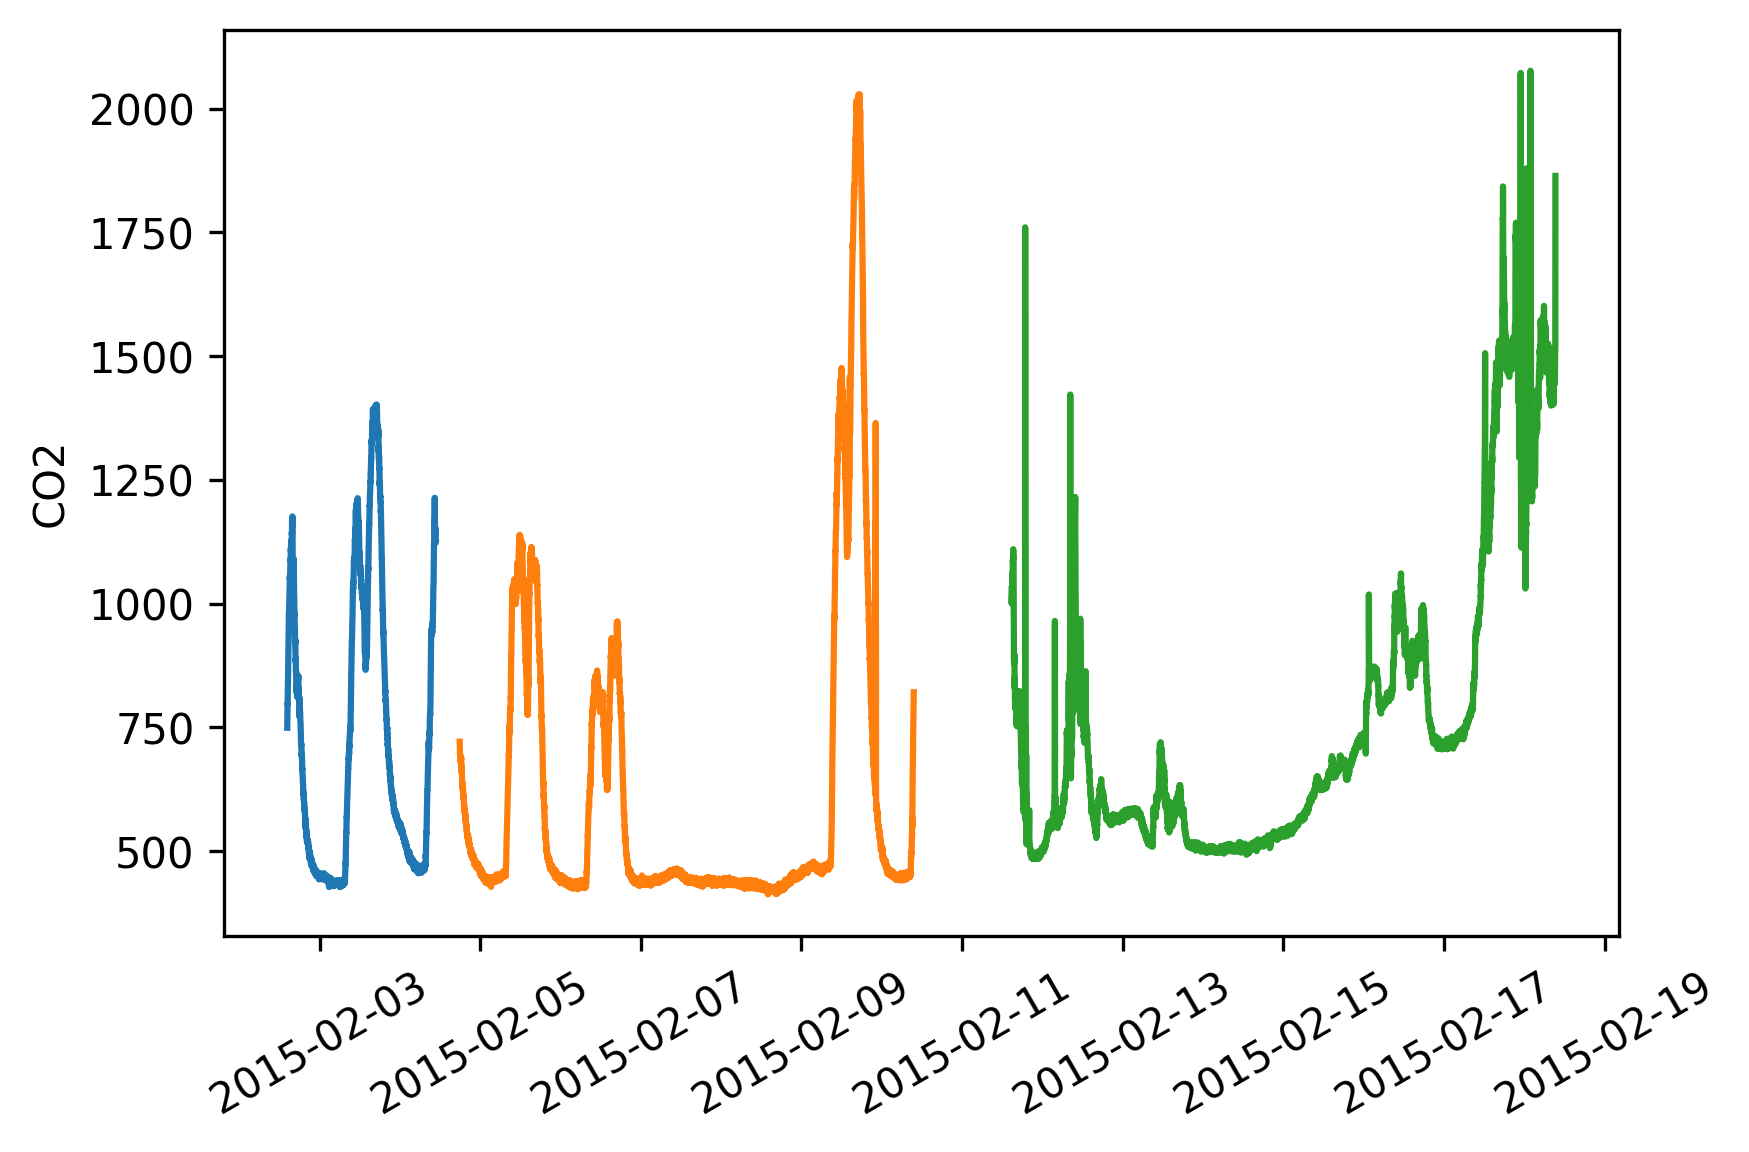

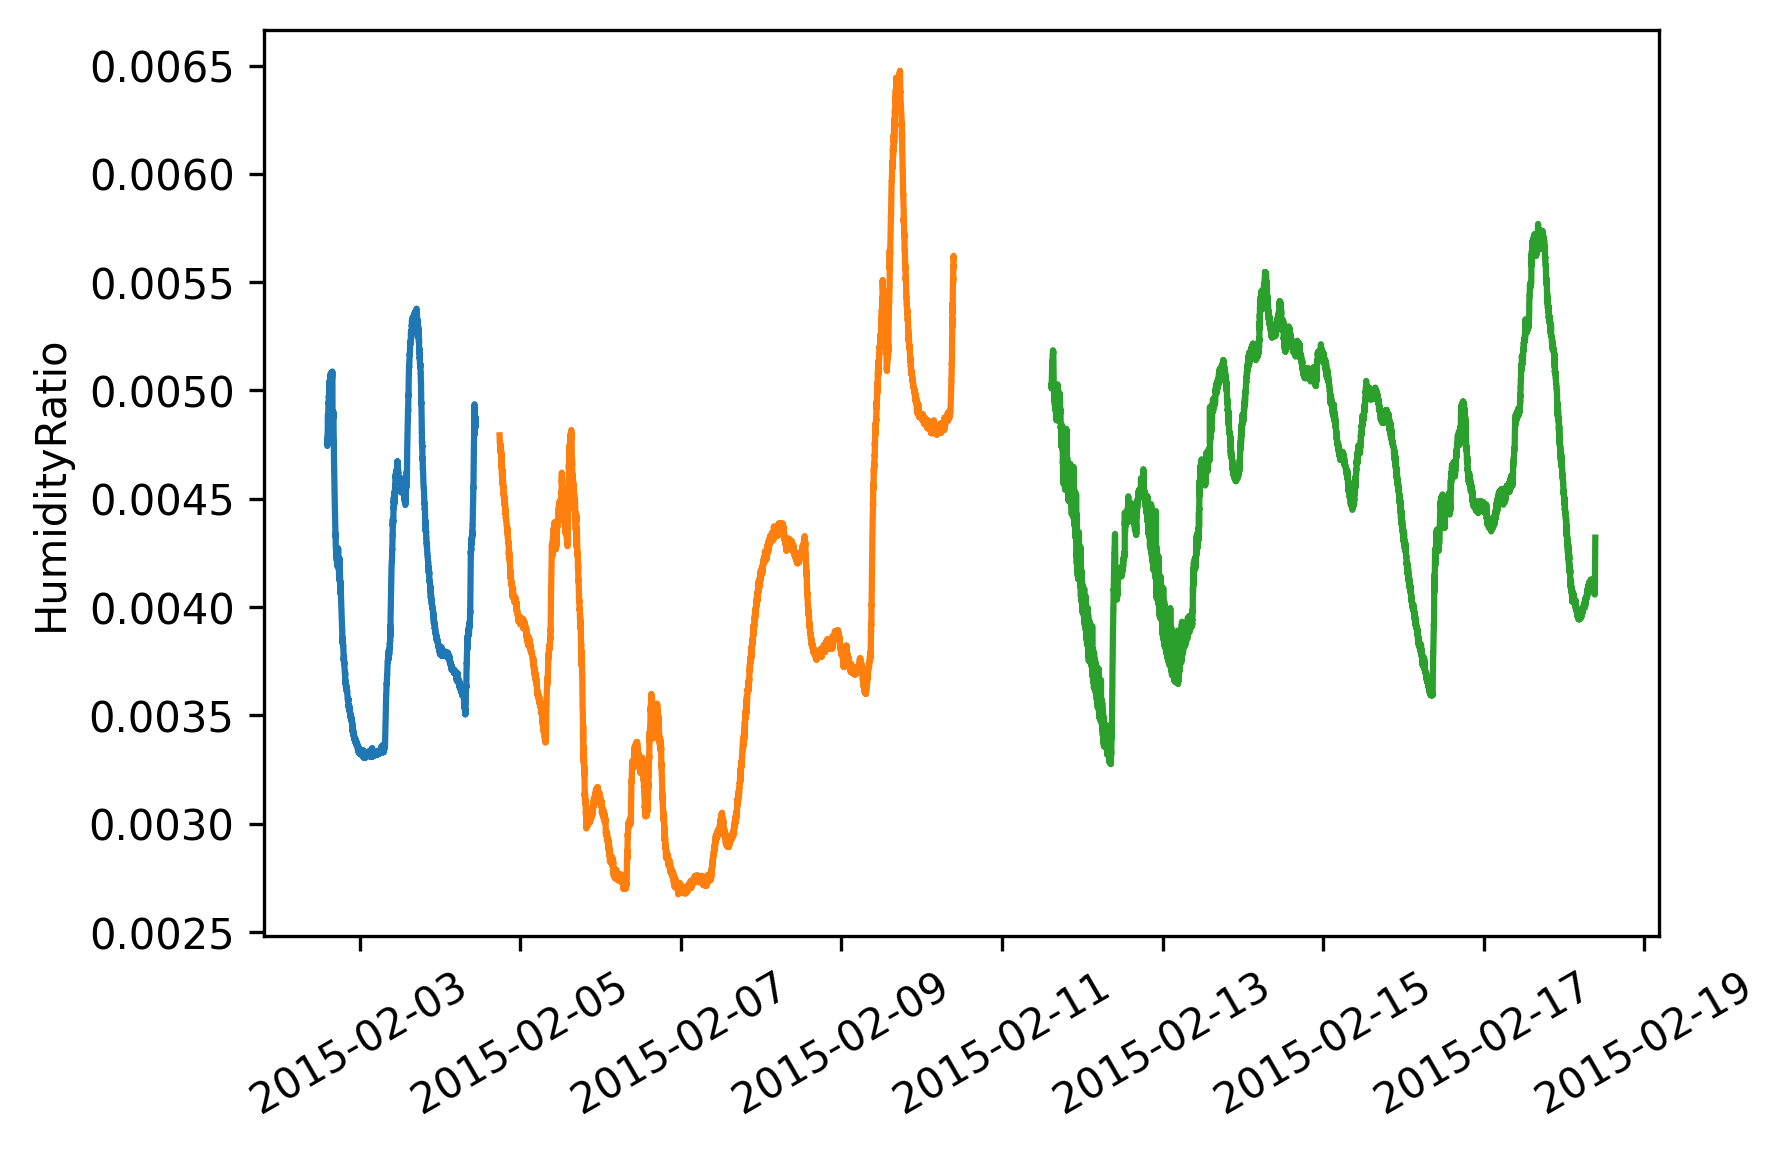

In [8]:

for i,col in enumerate(df1.columns):
    #plt.subplot(2,2,i+1)
    plt.plot(df1[col], label='ts1')
    plt.plot(df2[col], label='ts2')
    plt.plot(df3[col], label='ts3')
    plt.ylabel(col)
    plt.xticks(rotation = 30)
    #plt.legend()
    plt.show()
    



## Forecasting

Now we are ready to start with the forecasting. Example id given using *Humidity* column.
The implementation is provided by the library *statsmodel*. Method used is exponential smoothing with seasonality to cover daily periods. Records in a day are sixty (minutes in an hour) times 24 (hours), and for this reason season periods are of 1440.

In [21]:
ts1 = df1['Humidity'].copy()
ts2 = df2['Humidity'].copy()
ts3 = df3['Humidity'].copy()

seasonal_periods = 60 * 24

one = timedelta(minutes=1)

### Forward 
Here the selected forecasting tecnique is applied in a standard way, fitting it in the second time series in order to fill the hole betweeen itself and the third one time series.

In [22]:

from statsmodels.tsa.holtwinters import ExponentialSmoothing

es = ExponentialSmoothing(ts2,  seasonal_periods=seasonal_periods,seasonal='add').fit()
pred23 = es.predict(start=ts2.index[-1]+one, end=ts3.index[0]-one)


C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


### Backward 

While here time series are reverted, in order to apply the forecasting in the opposite side. In order to make it working, till the forecasting is made to works only forward (that's makes sense), it's importatn to reverse also all index... so we need to understand also how many record consist in teh gap ot fill it.


In [23]:
ts3r = ts3[::-1]
ts2r = ts2[::-1]

indexr = pd.date_range(start=ts2.index[0], end=ts3.index[-1], freq='min')
ts2r.index = indexr[-len(ts2r):]
ts3r.index = indexr[:len(ts3r)]

In [24]:


es = ExponentialSmoothing(ts3r,  seasonal_periods=seasonal_periods,seasonal='add').fit()



C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [25]:
pred32 = es.predict(start=ts3r.index[-1]+one, end=ts2r.index[0]-one)

In [26]:
pred32.index = pred23.index.copy()

### Interpolation 

Now we have the predicitons in the two directions, only needs to be interpolated. Result are shown below.

In [27]:
l = len(pred23)
pred = pd.Series([(pred32[i] * i + pred23[i] * (l -i) )/ l for i in range(l)], index=pred23.index.copy())


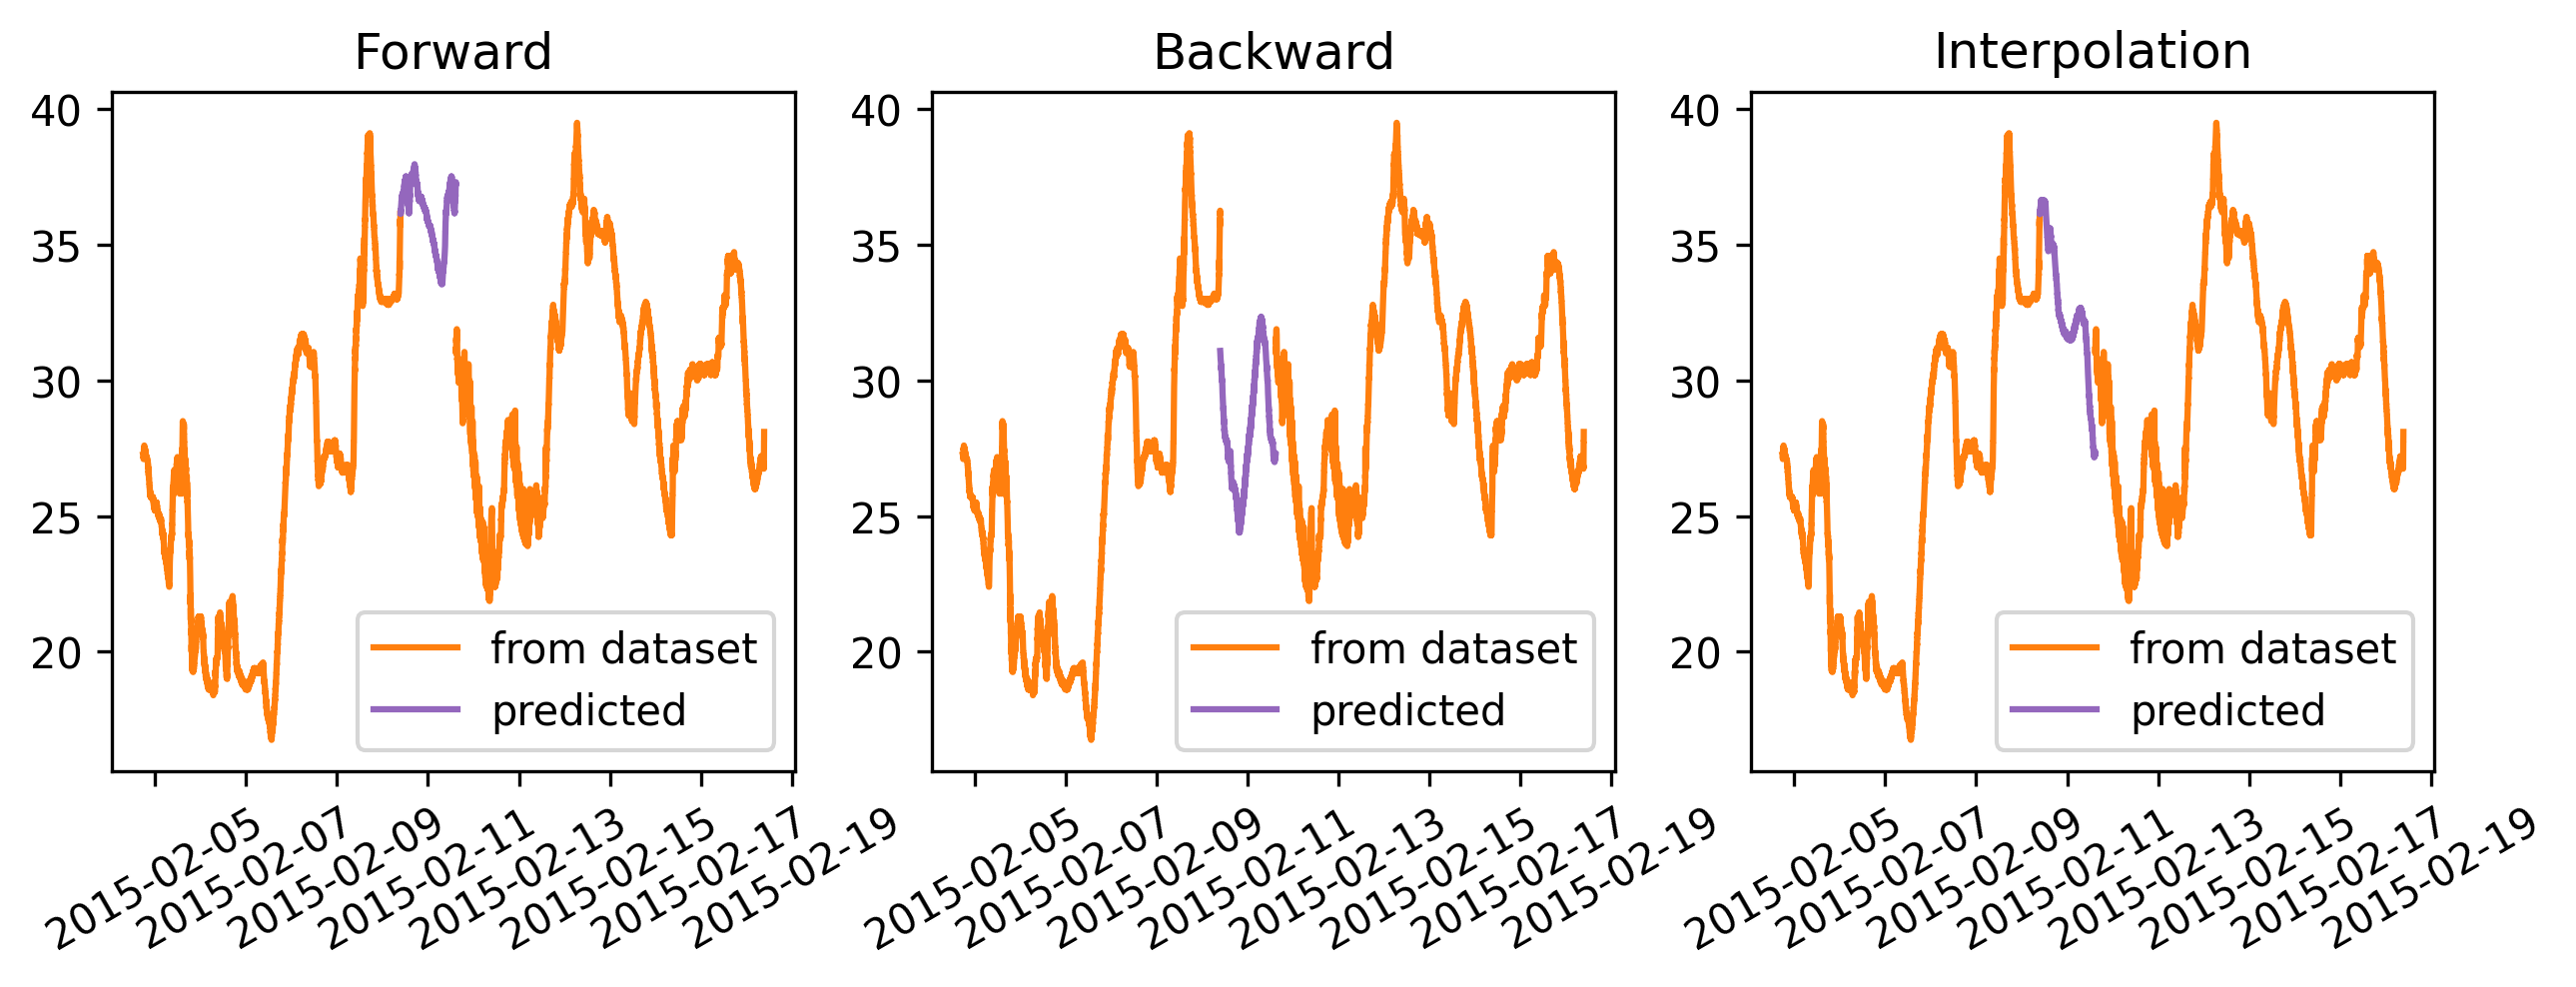

In [28]:
fig = plt.figure(figsize=(10,3))

plt.subplot(1,3,1)
plt.plot(ts2, color='C1', label='from dataset')
plt.plot(ts3, color='C1')
plt.plot(pred23, color='C4', label='predicted')
plt.title('Forward')
plt.legend()
plt.xticks(rotation = 30) 

plt.subplot(1,3,2)
plt.plot(ts2,  color='C1', label='from dataset')
plt.plot(ts3, color='C1')
plt.plot(pred32, color='C4', label='predicted')
plt.title('Backward')
plt.legend()
plt.xticks(rotation = 30) 

plt.subplot(1,3,3)
plt.plot(ts2,  color='C1', label='from dataset')
plt.plot(ts3,  color='C1')
plt.plot(pred, color='C4', label='predicted')
plt.title('Interpolation')
plt.legend()
plt.xticks(rotation = 30) 


plt.show()

## The method in a function 
Here is defined a function that given two time series returns the time series between them;
wi will apply it on the first gap .

In [9]:
def fillgap(firstTS, secondTS, seasonal_periods = 60 * 24):
    
    #PREPARATION
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    one = timedelta(minutes=1)
    secondTSr = secondTS[::-1].copy()
    firstTSr = firstTS[::-1].copy()
    indexr = pd.date_range(start=firstTS.index[0], end=secondTS.index[-1], freq='min')
    firstTSr.index = indexr[-len(firstTSr):]
    secondTSr.index = indexr[:len(secondTSr)]
    
    #FORWARD    
    es = ExponentialSmoothing(firstTS,  seasonal_periods=seasonal_periods,seasonal='add').fit()
    forwardPrediction = es.predict(start=firstTS.index[-1]+one, end=secondTS.index[0]-one)
    
    #BACKWARD
    es = ExponentialSmoothing(secondTSr,  seasonal_periods=seasonal_periods,seasonal='add').fit()
    backwardPrediction = es.predict(start=secondTSr.index[-1]+one, end=firstTSr.index[0]-one)
    
    #INTERPOLATION
    l = len(forwardPrediction)
    interpolation = pd.Series([(backwardPrediction[i] * i + forwardPrediction[i] * (l -i) )/ l for i in range(l)], index=forwardPrediction.index.copy())
  
    return interpolation



In [44]:
ts1 = df1['Humidity'].copy()
ts2 = df2['Humidity'].copy()
gap = fillgap(ts1,ts2)

C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


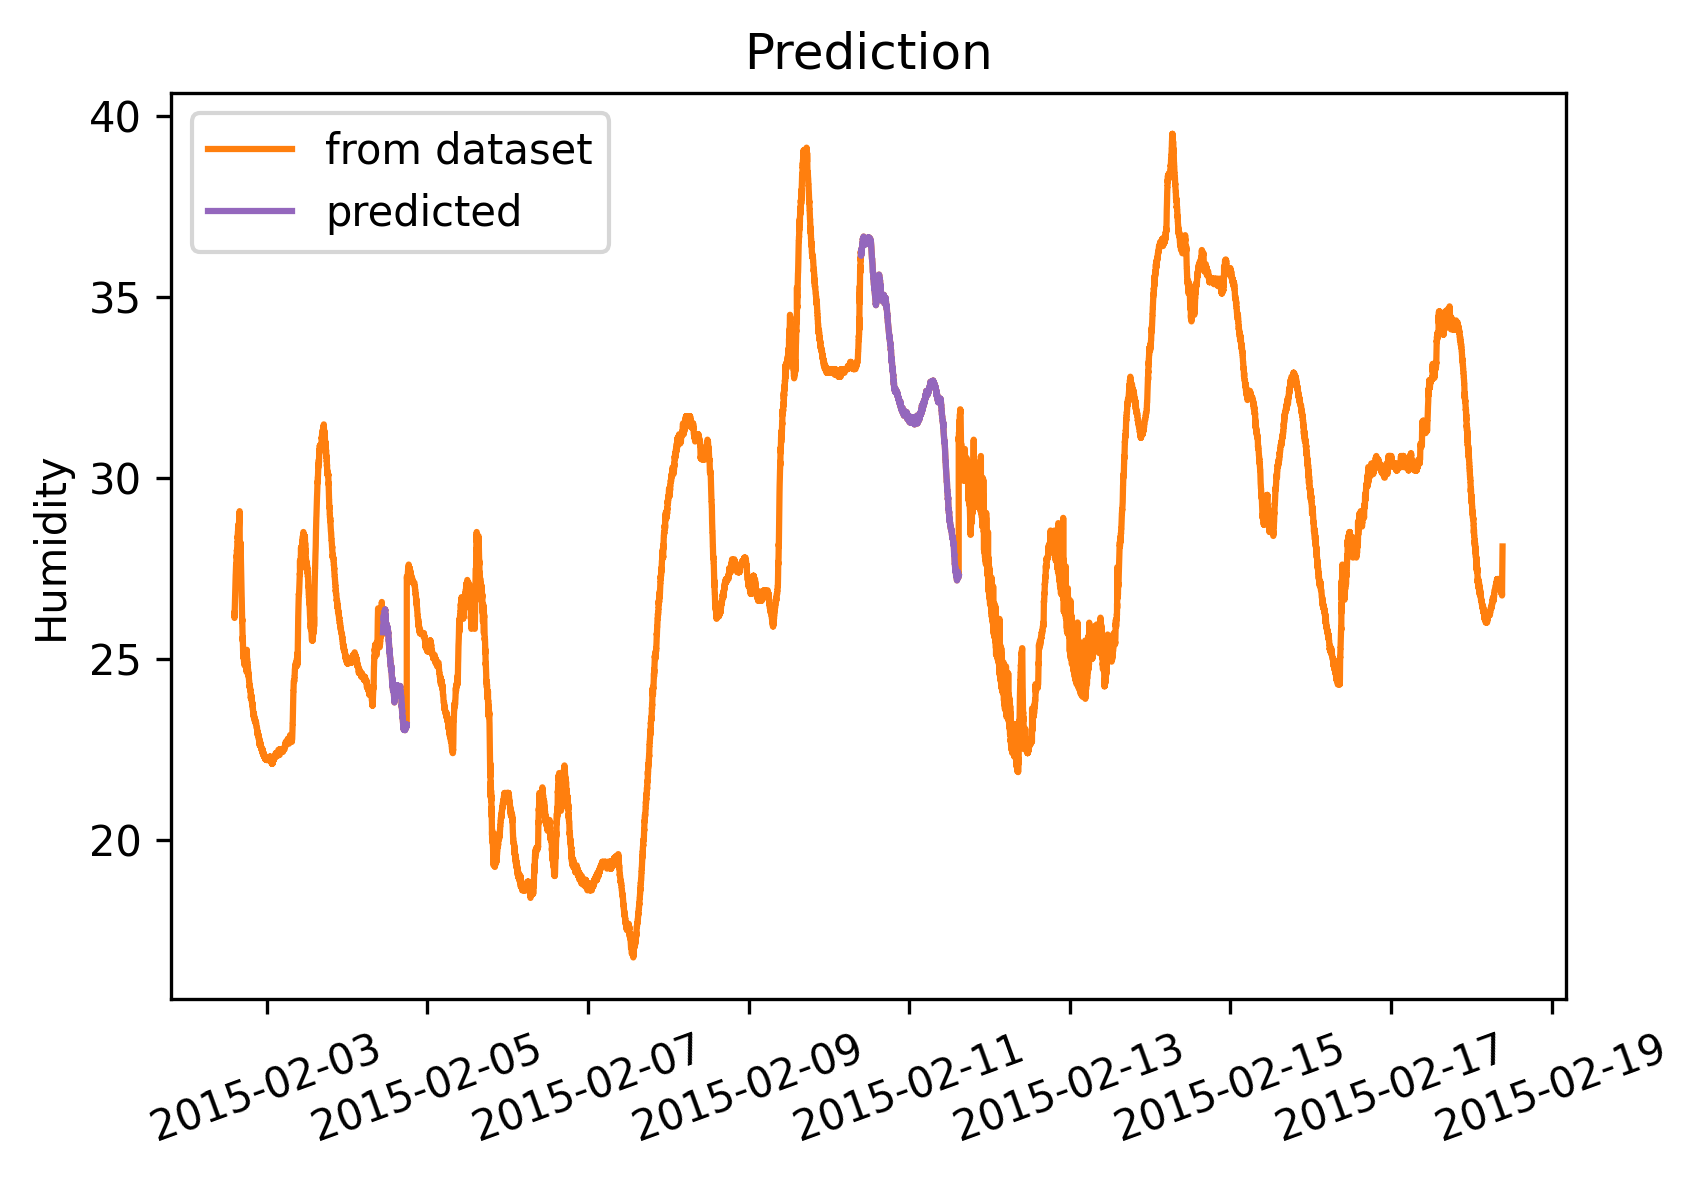

In [46]:
ts = pd.concat([ts1,gap,ts2,pred,ts3])

plt.plot(ts, color='C1', label='from dataset')
plt.plot(gap, color='C4')
plt.plot(pred, color='C4', label='predicted')
plt.ylabel('Humidity')
plt.title('Prediction')
plt.legend()
plt.xticks(rotation = 20)

plt.show()

## Application and resolution in the dataset 
Here the mothos is apply fro the two gaps and for each column of the dataset, in order to creating a new one long dataset without interruption.

In [10]:
#First dataset
df1 = pd.read_csv('datatest.txt',index_col=1,parse_dates=True)
df1.set_index(pd.date_range(start=df1.index[0], end=df1.index[-1], freq='min'), inplace=True)
df1.drop(['date','Occupancy','Light'], axis=1, inplace=True)

#Second dataset
df2=pd.read_csv(r'datatraining.txt', index_col=1,parse_dates=True)
df2.set_index(pd.date_range(start=df2.index[0], end=df2.index[-1], freq='min'), inplace=True)
df2.drop(['date','Occupancy','Light'], axis=1, inplace=True)

#Third dataset
df3= pd.read_csv('datatest2.txt',index_col=1,parse_dates=True)
df3.set_index(pd.date_range(start=df3.index[0], end=df3.index[-1], freq='min'), inplace=True)
df3.drop(['date','Occupancy','Light'], axis=1, inplace=True)

df1.head()

,Temperature,Humidity,CO2,HumidityRatio
2015-02-02 14:19:00,23.7000,26.272,749.200000,0.004764
2015-02-02 14:20:00,23.7180,26.290,760.400000,0.004773
2015-02-02 14:21:00,23.7300,26.230,769.666667,0.004765
2015-02-02 14:22:00,23.7225,26.125,774.750000,0.004744
2015-02-02 14:23:00,23.7540,26.200,779.000000,0.004767


In [11]:
gap1 = pd.DataFrame()
gap2 = pd.DataFrame()

for col in df1.columns:
    ts1 = df1[col].copy()
    ts2 = df2[col].copy()
    ts3 = df3[col].copy()
    gap1[col] = fillgap(ts1,ts2)
    gap2[col] = fillgap(ts2,ts3)
    

C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\carlo\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Op

In [15]:
df = pd.DataFrame(columns = [col for col in df1.columns])
df = df.append(df1)
df = df.append(gap1)
df = df.append(df2)
df = df.append(gap2)
df = df.append(df3)

df

,Temperature,Humidity,CO2,HumidityRatio
2015-02-02 14:19:00,23.7000,26.2720,749.200000,0.004764
2015-02-02 14:20:00,23.7180,26.2900,760.400000,0.004773
2015-02-02 14:21:00,23.7300,26.2300,769.666667,0.004765
2015-02-02 14:22:00,23.7225,26.1250,774.750000,0.004744
2015-02-02 14:23:00,23.7540,26.2000,779.000000,0.004767
...,...,...,...,...
2015-02-18 09:15:00,20.8150,27.7175,1505.250000,0.004213
2015-02-18 09:16:00,20.8650,27.7450,1514.500000,0.004230
2015-02-18 09:17:00,20.8900,27.7450,1521.500000,0.004237
2015-02-18 09:18:00,20.8900,28.0225,1632.000000,0.004279


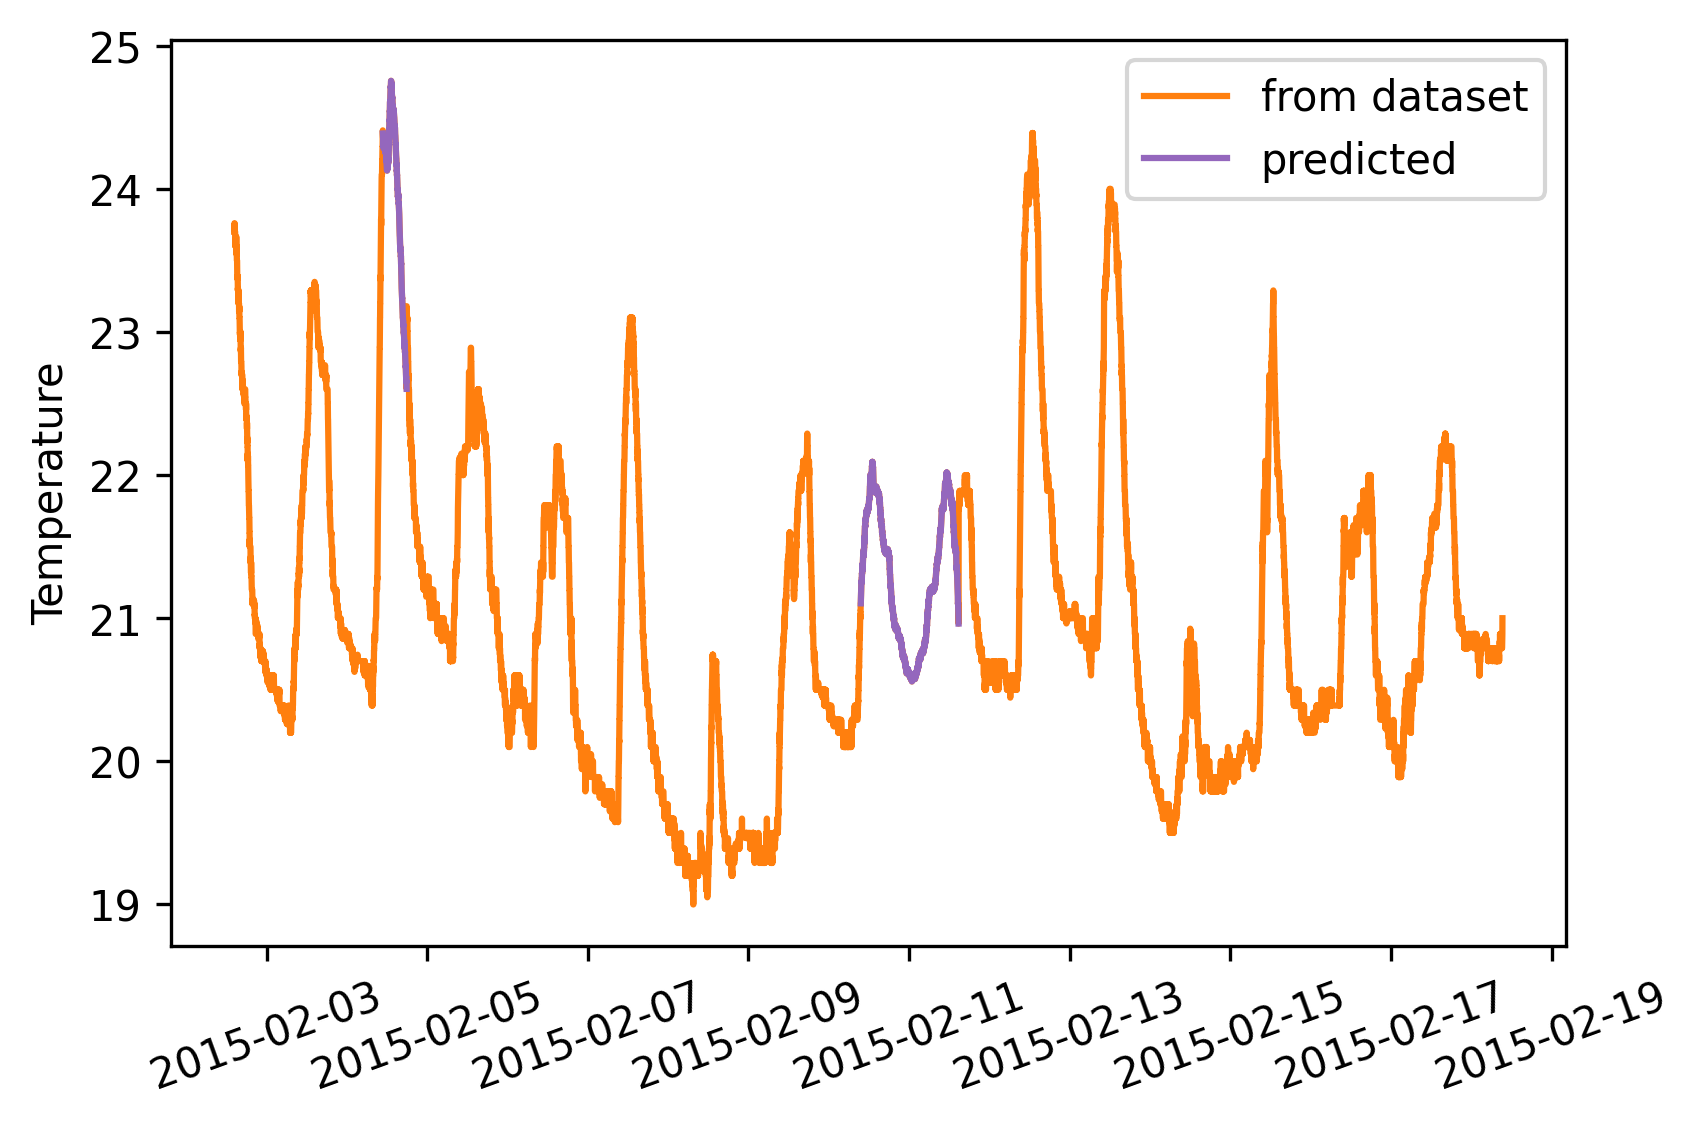

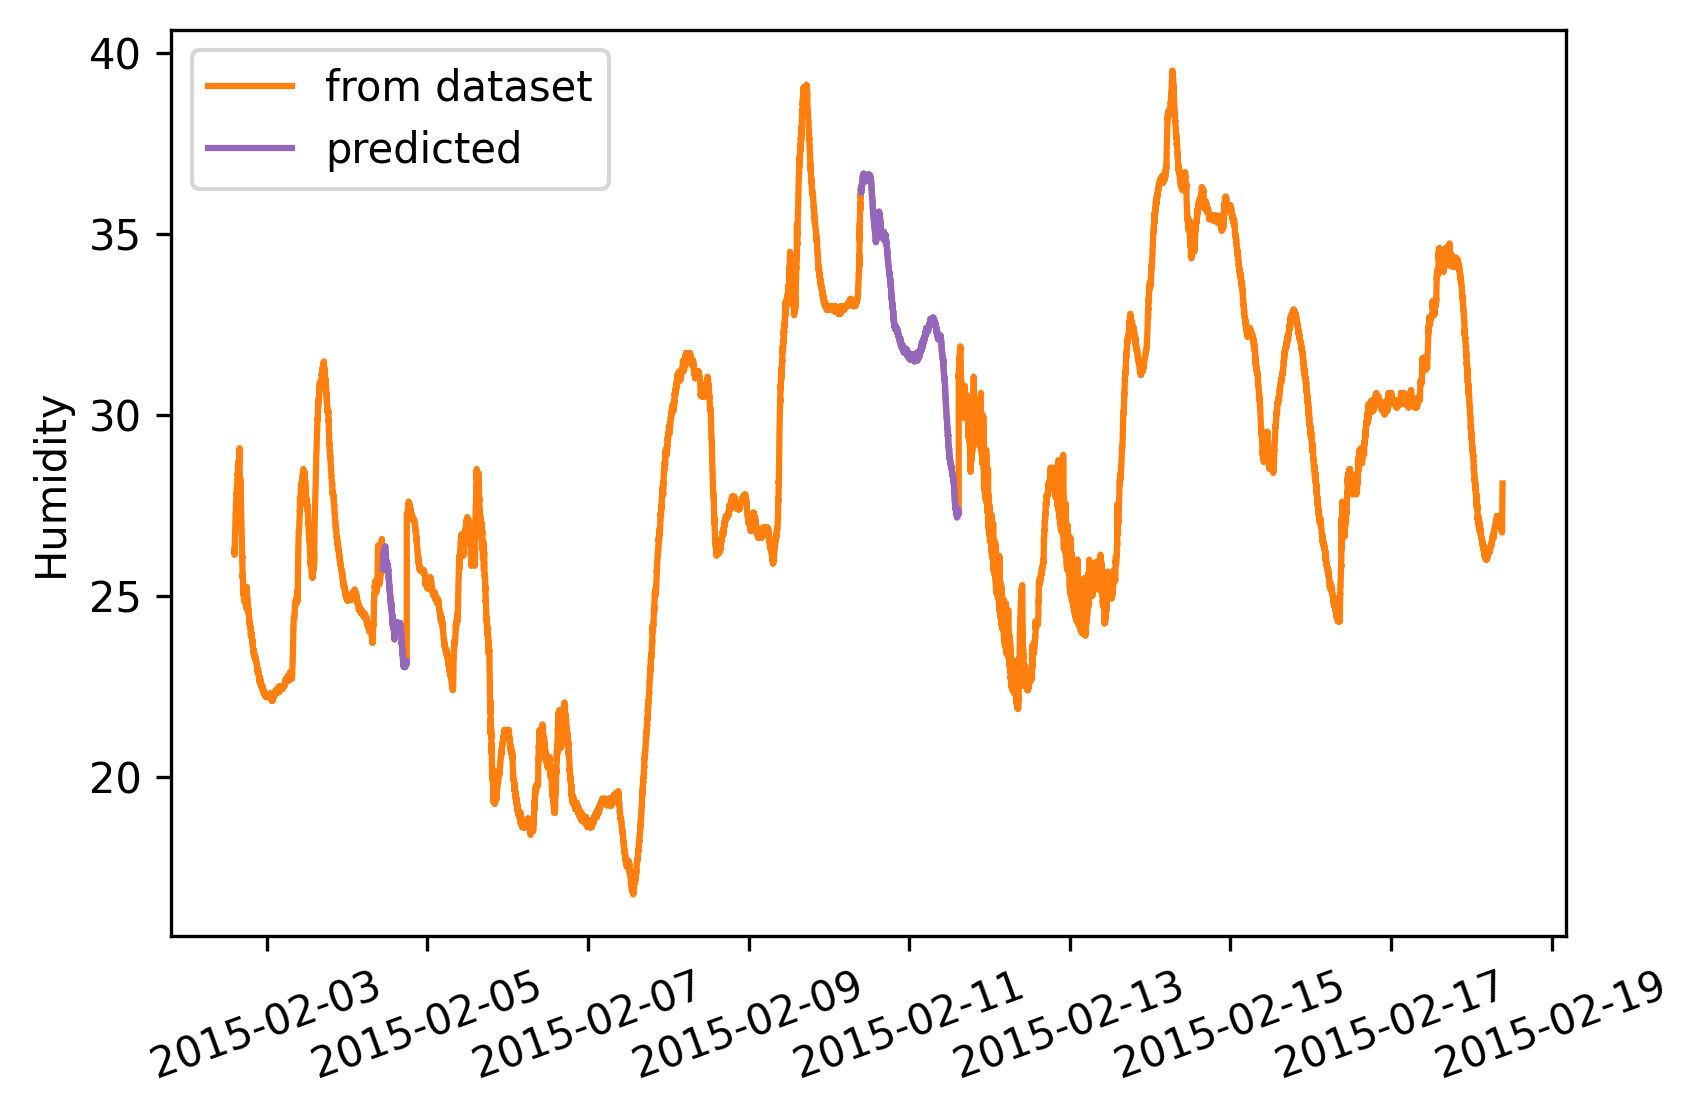

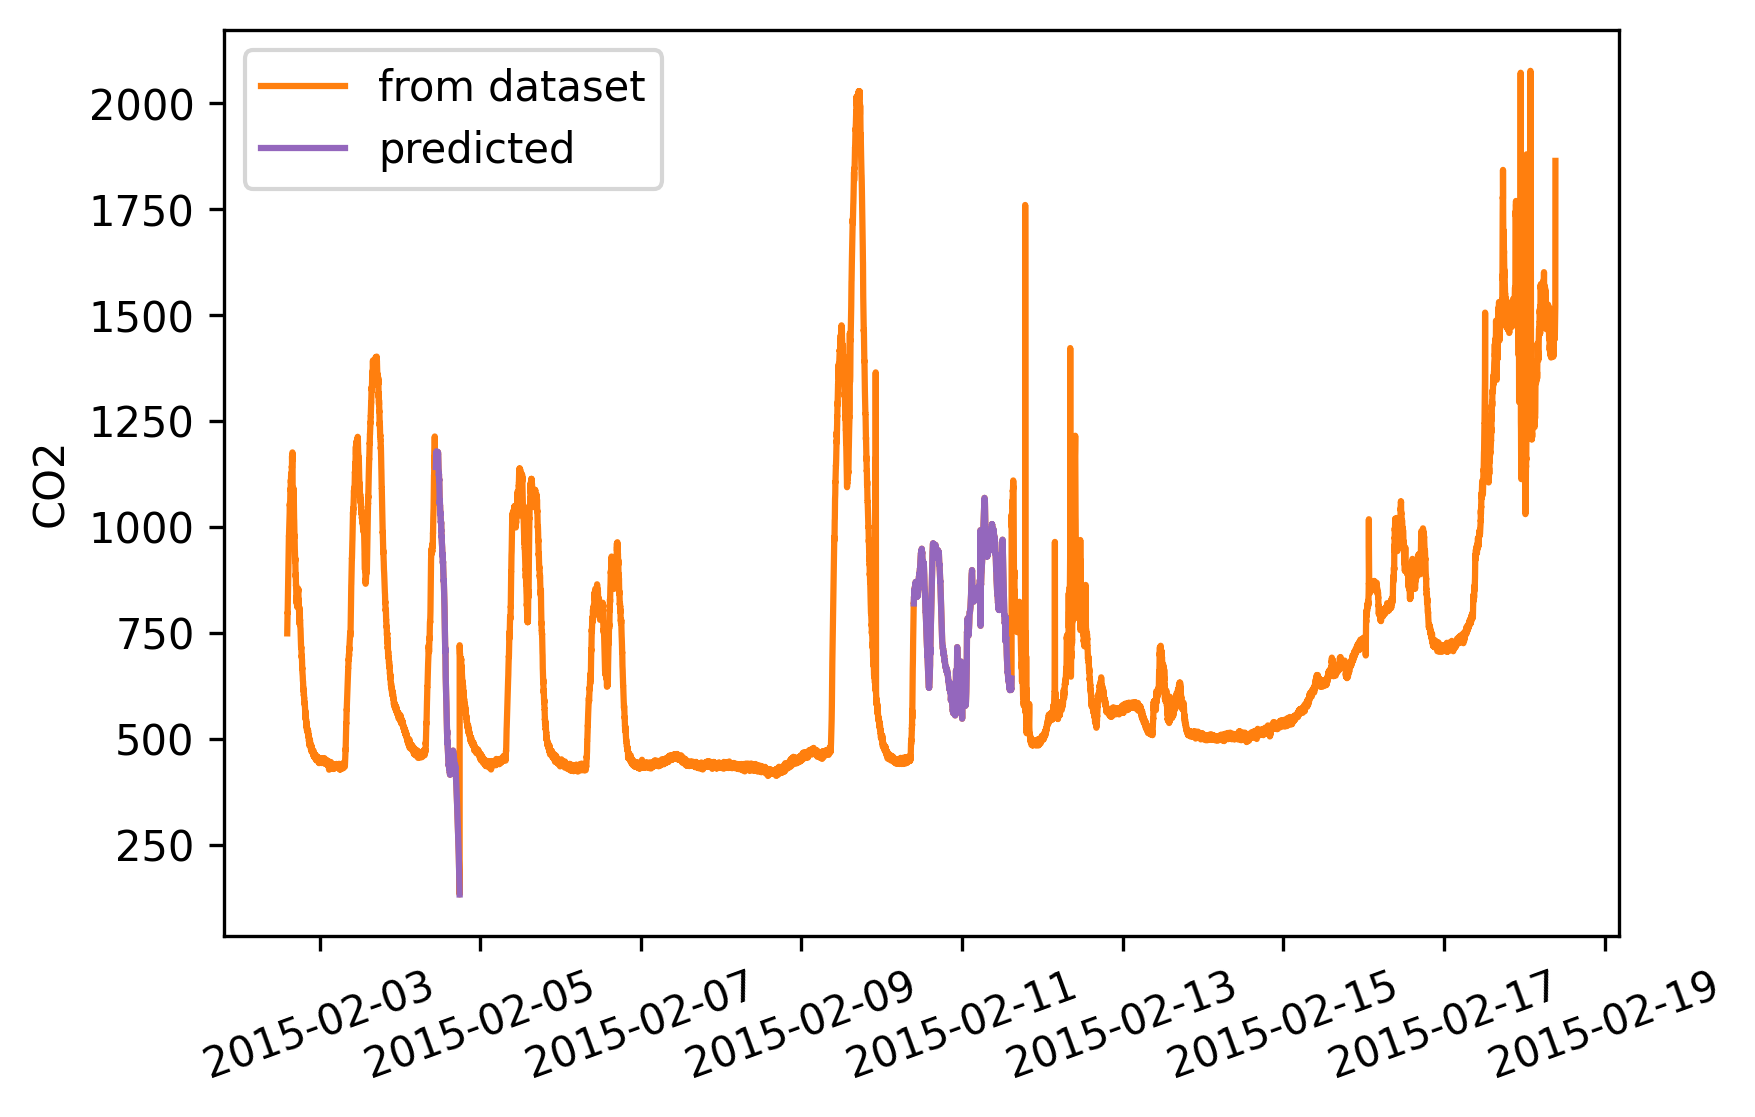

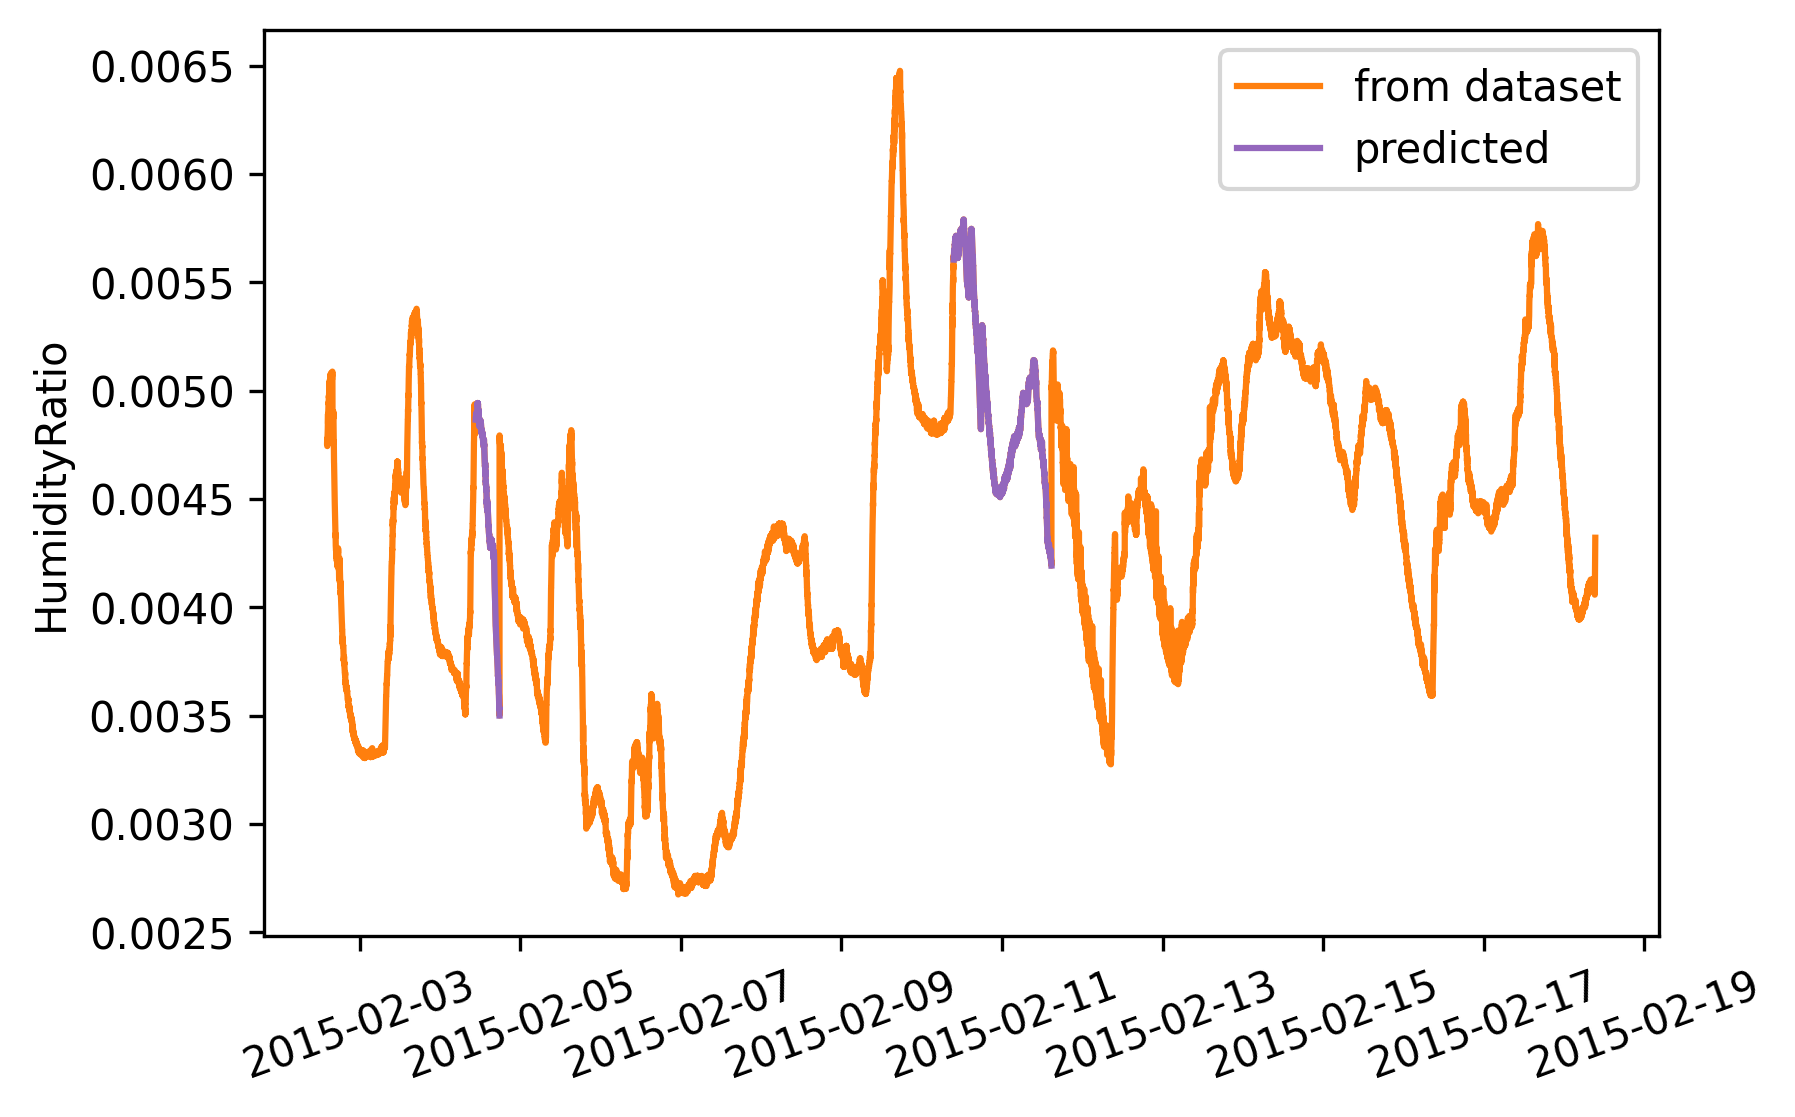

In [19]:
for i,col in enumerate(df.columns):
    plt.plot(df[col],  color='C1', label='from dataset')
    plt.plot(gap1[col], color='C4')
    plt.plot(gap2[col], color='C4', label='predicted')
    plt.ylabel(col)
    plt.legend()
    plt.xticks(rotation = 20) 
    plt.show()

In [18]:
df.to_csv('ts_with-gaps.csv')
df1.to_csv('ts1.csv')
df2.to_csv('ts2.csv')
df3.to_csv('ts3.csv')
gap1.to_csv('gap1.csv')
gap2.to_csv('gap2.csv')

# Thanks for attention